In [30]:
import intake
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import datetime as dt
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import tqdm
import hvplot.xarray
from IPython.display import Image

def get_intake_cat():

    '''
    Return the intake catalog for barra
    '''

    #See here: https://opus.nci.org.au/pages/viewpage.action?pageId=264241965
    data_catalog = intake.open_esm_datastore("/g/data/ob53/catalog/v2/esm/catalog.json")

    return data_catalog

def get_intake_cat_era5():

    '''
    Return the intake catalog for era5
    '''

    #See here: https://opus.nci.org.au/pages/viewpage.action?pageId=264241965
    data_catalog = intake.open_esm_datastore("/g/data/rt52/catalog/v2/esm/catalog.json")

    return data_catalog

def load_barra_static(domain_id,lon_slice,lat_slice):

    '''
    For a barra domain, load static variables
    domain_id: for barra, either AUS-04 or AUST-11
    lat_slice: a slice to restrict lat domain
    lon_slice: a slice to restrict lon domain
    '''

    data_catalog = get_intake_cat()
    orog = data_catalog.search(variable_id="orog",domain_id=domain_id).to_dask().sel(lon=lon_slice, lat=lat_slice)
    lsm = data_catalog.search(variable_id="sftlf",domain_id=domain_id).to_dask().sel(lon=lon_slice, lat=lat_slice)

    return orog.orog, (lsm.sftlf >= 0.5) * 1

def load_era5_static(lon_slice,lat_slice,t1,t2):

    '''
    For ERA5, load static variables using the first time step of the period
    lat_slice: a slice to restrict lat domain
    lon_slice: a slice to restrict lon domain
    t1: start time in %Y-%m-%d %H:%M"
    t1: end time in %Y-%m-%d %H:%M"
    '''

    data_catalog = get_intake_cat_era5()
    time_starts = pd.date_range(pd.to_datetime(t1).replace(day=1),t2,freq="MS").strftime("%Y%m%d").astype(int).values
    time_ends = [(t + dt.timedelta(days=32)).replace(day=1) - dt.timedelta(days=1) for t in pd.to_datetime(time_starts,format="%Y%m%d")]
    times = [str(t1) + "-" + t2.strftime("%Y%m%d") for t1,t2 in zip(time_starts,time_ends)]

    #times = pd.date_range(pd.to_datetime(t1).replace(day=1),t2,freq="MS").strftime("%Y%m").astype(int).values
    orog = data_catalog.search(variable="z",product="era5-reanalysis",time_range=times,levtype="sfc").to_dask()
    orog = orog.isel(latitude=slice(None,None,-1))
    orog = orog.rename({"longitude":"lon","latitude":"lat"}).sel(lon=lon_slice, lat=lat_slice).isel(time=0)
    lsm = data_catalog.search(variable="lsm",product="era5-reanalysis",time_range=times).to_dask()
    lsm = lsm.isel(latitude=slice(None,None,-1))
    lsm = lsm.rename({"longitude":"lon","latitude":"lat"}).sel(lon=lon_slice, lat=lat_slice).isel(time=0)

    return orog.z, (lsm.lsm >= 0.5) * 1

def remove_era5_inland_lakes(lsm):

    '''
    From an ERA5 land sea mask dataarray (lsm), assign inland lakes in south Australia to land points
    '''

    return xr.where((lsm.lon>135) & (lsm.lon<142) & (lsm.lat>-32.25) & (lsm.lat<-25), 1, lsm).T

In [31]:
lat_slice = slice(-45,-5)
lon_slice = slice(110,155)
# lat_slice = slice(-45,-38)
# lon_slice = slice(142,149)

orog, lsm = load_era5_static(lon_slice,lat_slice,"2024-01-01","2024-01-01")
#orog, lsm = load_barra_static("AUS-11",lon_slice,lat_slice)
#orog, lsm = load_barra_static("AUST-04",lon_slice,lat_slice)

orog, lsm = load_era5_static(lon_slice,lat_slice,"2024-01-01 00:00","2024-01-01 00:00"); lsm = remove_era5_inland_lakes(lsm)

100%|██████████| 1804/1804 [00:02<00:00, 670.06it/s]
/jobfs/127008726.gadi-pbs/ipykernel_1441498/3702442447.py:104: RuntimeWarning: invalid value encountered in divide
  stack = stack / np.abs(stack)


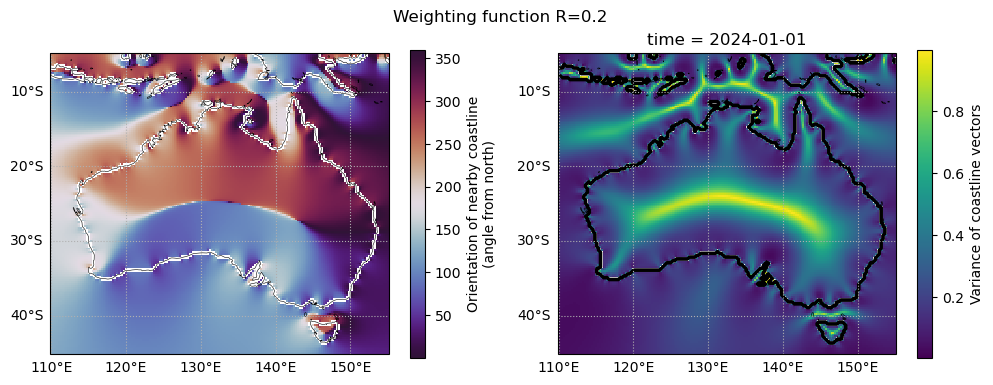

In [32]:
def plot_angles(angles_ds):

    plt.figure(figsize=[12,4])
    
    ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
    c=angle_ds.angle.plot(cmap="twilight_shifted",add_colorbar=False)
    #xr.plot.contour(lsm,colors=["k"])
    cb=plt.colorbar(c)
    ax.coastlines(lw=0.4)
    ax.gridlines(draw_labels=["left","bottom"],ls=":")
    cb.set_label("Orientation of nearby coastline\n(angle from north)")
    
    ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
    c=angle_ds.variance.plot(add_colorbar=False)
    xr.plot.contour(lsm,colors=["k"])
    cb=plt.colorbar(c)
    ax.coastlines(lw=0.4)
    ax.gridlines(draw_labels=["left","bottom"],ls=":")
    cb.set_label("Variance of coastline vectors")

def get_weights(x, p=4, q=4, R=5, slope=-1):
   """
   x the distance
   Let y1 = m1 * (x / R) ** (-p) for x > R.
   Let y2 = S - m2 * (x / R) ** (q) for x <= R.
   Equate y1 and y2 and their derivative at x = R to get
   S = m1 + m2
   slope = -p * m1 = -q * m2 => m1 = -slope/p and m2 = -slope/q
   Thus specifying p, q, R, and the function's slope at x=R determines m1, m2 and S.
   """
   m1 = -slope/p
   m2 = -slope/q
   S = m1 + m2
   y = np.zeros_like(x,dtype=np.float32)
   
   y[x > R] = m1 * (x[x > R] / R) ** (-p)
   y[x <= R] = S - m2 * (x[x <= R] / R) ** (q)
   y[x==0] = np.nan
   return y

def get_coastline_angle_kernel(lsm,R=0.2):

    '''
    Ewan's method with help from Jarrah.
    
    Construct a "kernel" for each coastline point based on the anlgle between that point and all other points in the domain, then average..

    Input
    lsm: xarray dataarray with a binary lsm, and lat lon info

    Output
    An xarray dataset with an array of coastline angles (0-360 degrees from N) for the labelled coastline array, as well as an array
    of angle variance as an estimate of how many coastlines are influencing a given point
    '''

    #From the land sea mask define the coastline and a label array
    coast_label = find_boundaries(lsm)*1
    land_label = lsm.values

    #Get lat lon info for domain and coastline, and convert to lower precision
    lon = lsm.lon.values
    lat = lsm.lat.values
    xx,yy = np.meshgrid(lon,lat)
    xx = xx.astype(np.float16)
    yy = yy.astype(np.float16)    

    #Define coastline x,y indices from the coastline mask
    xl, yl = np.where(coast_label)

    #Get coastline lat lon vectors
    yy_t = np.array([yy[xl[t],yl[t]] for t in np.arange(len(yl))])
    xx_t = np.array([xx[xl[t],yl[t]] for t in np.arange(len(xl))])

    #Repeat the 2d lat lon array over a third dimension (corresponding to the coast dim)
    yy_rep=np.repeat(yy[:,:,np.newaxis],yl.shape[0],axis=2)
    xx_rep=np.repeat(xx[:,:,np.newaxis],xl.shape[0],axis=2)

    #Compute the differences in complex space for each coastline points. 
    stack = np.zeros(xx_rep.shape,dtype=np.complex64)
    for t in tqdm.tqdm(range(yl.shape[0])):
        stack[:,:,t] = (yy_rep[:,:,t] - yy_t[t])*1j + (xx_rep[:,:,t] - xx_t[t])    
    del yy_rep,xx_rep
    
    #Reorder to work with the array easier
    stack = np.moveaxis(stack, -1, 0)

    #Get the real part of the complex numbers
    stack_abs = np.abs(stack,dtype=np.float32)
    
    #Create an inverse distance weighting function
    #weights = get_weights(np.abs(stack), p=4, q=2, R=R, slope=-1)
    weights = get_weights(stack_abs, p=4, q=2, R=R, slope=-1)

    #Take the weighted mean and convert complex numbers to an angle
    mean_angles = np.mean( (weights*stack) , axis=0)
    mean_angles = np.angle(mean_angles)    

    #Flip the angles inside the coastline for convention, and convert range to 0 to 2*pi
    mean_angles = np.where(land_label==1,(mean_angles+np.pi) % (2*np.pi),mean_angles % (2*np.pi))
    
    #Calculate the weighted circular variance
    total_weight = np.sum(weights, axis=0)
    weights = weights/total_weight
    stack = stack / np.abs(stack)
    variance = 1 - np.abs(np.sum(weights*stack, axis=0))  

    #Reverse the angles for consistency with previous methods, and convert to degrees
    mean_angles = -np.rad2deg(mean_angles) + 360

    #Convert to dataarrays
    angle_da = xr.DataArray(mean_angles,coords={"lat":lat,"lon":lon})
    var_da = xr.DataArray(variance,coords={"lat":lat,"lon":lon})

    return xr.Dataset({"angle":angle_da,"variance":var_da})
    
#mean_angles, stack, variance = get_coastline_angle_circle(find_boundaries(lsm.values,mode="inner")*1, lsm.values, lsm)

#angle_ds = get_coastline_angle_kernel(lsm,R=0.1); plot_angles(angle_ds); plt.suptitle("Weighting function R=0.1")
angle_ds = get_coastline_angle_kernel(lsm,R=0.2); plot_angles(angle_ds); plt.suptitle("Weighting function R=0.2")
plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/coast_map_era5_var.jpeg",dpi=800,bbox_inches="tight")

Text(0.5, 1.0, 'Nearest neighbout interpolation for coastlines')

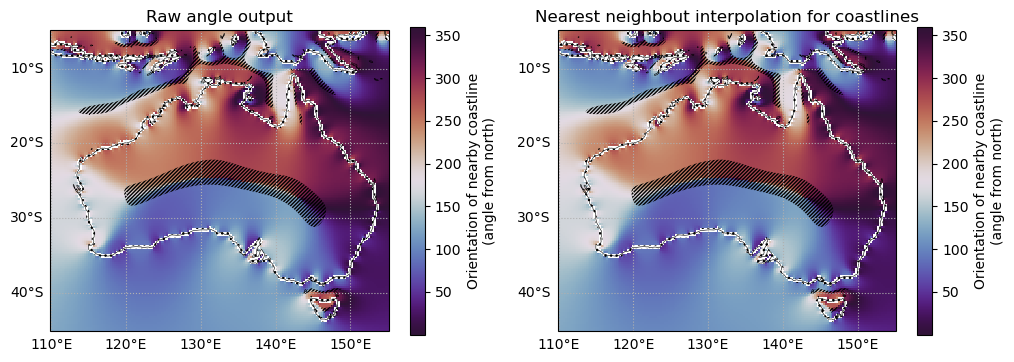

In [33]:
def fill_coastline_angles(angle_ds):

    '''
    Fill in coastline nan values for the kernel method. Uses nearest neighbour
    Note that angles aren't defined at the coastline for this method
    '''

    # ravel all points and find the valid ones
    points = angle_ds.angle.values.ravel()
    valid = ~np.isnan(points)
    points_valid = points[valid]
    
    # construct arrays of (x, y, z) points, masked to only include the valid points
    xx, yy = np.meshgrid(angle_ds.lon.values, angle_ds.lat.values)
    xx, yy = xx.ravel(), yy.ravel()
    xxv = xx[valid]
    yyv = yy[valid]
    
    # feed these into the interpolator, and also provide the target grid
    interpolated = scipy.interpolate.griddata(np.stack([xxv, yyv]).T, points_valid, (xx, yy), method="nearest")
    
    # reshape to match the original array and replace the DataArray values with
    # the interpolated data
    angle_ds["angle_interp"] = (("lat","lon"),interpolated.reshape(angle_ds.angle.shape))
    angle_ds["coast"] = (("lat","lon"),np.isnan(angle_ds.angle).values * 1)

    return angle_ds

angle_ds = fill_coastline_angles(angle_ds)

plt.figure(figsize=[12,4])

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
c=angle_ds.angle.plot(cmap="twilight_shifted",add_colorbar=False)
xr.plot.contourf(angle_ds.variance,levels=[0.,0.6],hatches=["","/////////"],colors="none",add_colorbar=False)
xr.plot.contourf(angle_ds.coast,levels=[0.,0.6],hatches=["","..."],colors="none",add_colorbar=False)
cb=plt.colorbar(c)
ax.coastlines(lw=0.4)
ax.gridlines(draw_labels=["left","bottom"],ls=":")
cb.set_label("Orientation of nearby coastline\n(angle from north)")
plt.title("Raw angle output")

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
c=angle_ds.angle.plot(cmap="twilight_shifted",add_colorbar=False)
xr.plot.contourf(angle_ds.variance,levels=[0.,0.6],hatches=["","/////////"],colors="none",add_colorbar=False)
xr.plot.contourf(angle_ds.coast,levels=[0.,0.6],hatches=["","..."],colors="none",add_colorbar=False)
cb=plt.colorbar(c)
ax.coastlines(lw=0.4)
ax.gridlines(draw_labels=["left","bottom"],ls=":")
cb.set_label("Orientation of nearby coastline\n(angle from north)")
plt.title("Nearest neighbout interpolation for coastlines")

## Compare angles with method that calculates angles from neighbouring coastal points

In [34]:
#Image(filename='/home/548/ab4502/working/sea_breeze/figs/aus_coast_fit.png') 

## Zoom in on some interesting regions

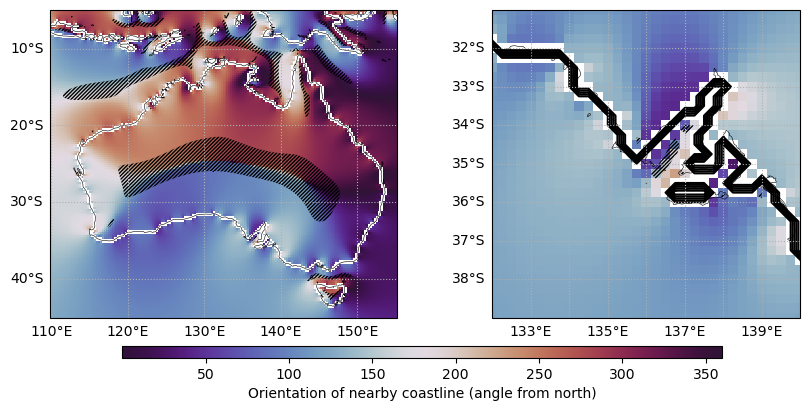

In [35]:
plt.figure(figsize=[10,4])

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
c=angle_ds.angle.plot(cmap="twilight_shifted",add_colorbar=False)
#xr.plot.contour(lsm,colors=["k"])
xr.plot.contourf(angle_ds.variance,levels=[0.,0.5],hatches=["","/////////"],colors="none",add_colorbar=False)
ax.coastlines(lw=0.4)
ax.gridlines(draw_labels=["left","bottom"],ls=":")
plt.title("")
# ax.set_xlim([120,135])
# ax.set_ylim([-20,-5])

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
c=angle_ds.angle.plot(cmap="twilight_shifted",add_colorbar=False)
xr.plot.contourf(angle_ds.variance,levels=[0.,0.5],hatches=["","/////////"],colors="none",add_colorbar=False)
xr.plot.contour(lsm,colors=["k"])
ax.coastlines(lw=0.4)
ax.gridlines(draw_labels=["left","bottom"],ls=":")

ax.set_xlim([132,140])
ax.set_ylim([-39,-31])
plt.title("")

cax=plt.axes([0.2,0.01,0.6,0.03])
cb=plt.colorbar(c,cax=cax,orientation="horizontal")
cb.set_label("Orientation of nearby coastline (angle from north)")

plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/coast_map_era5.jpeg",dpi=800,bbox_inches="tight")

## Use hvplot to zoom in

In [36]:
angle_ds.angle.hvplot(cmap="twilight_shifted",width=800,height=800)

:Image   [lon,lat]   (angle)

## Plot the actual weighting functions for an example coast point

/jobfs/127008726.gadi-pbs/ipykernel_1441498/2754434712.py:29: RuntimeWarning: divide by zero encountered in divide
  weights = ((1/(np.abs(stack)))**4).astype(np.float16)
/jobfs/127008726.gadi-pbs/ipykernel_1441498/2754434712.py:33: RuntimeWarning: divide by zero encountered in divide
  plt.plot(x, (1/x**4), marker="o")


Text(0.5, 1.0, 'R=0.1')

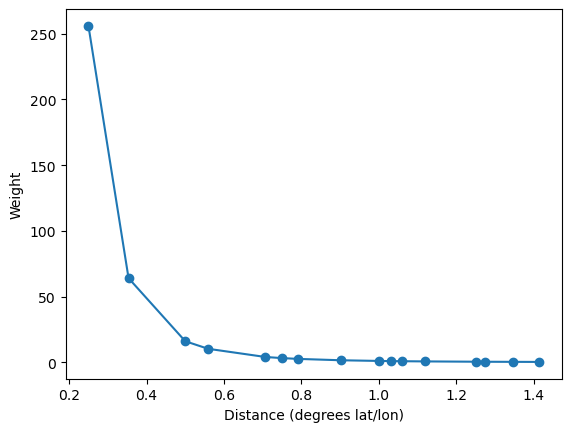

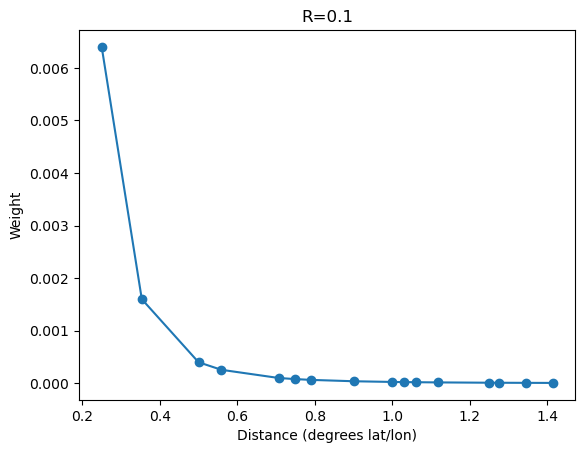

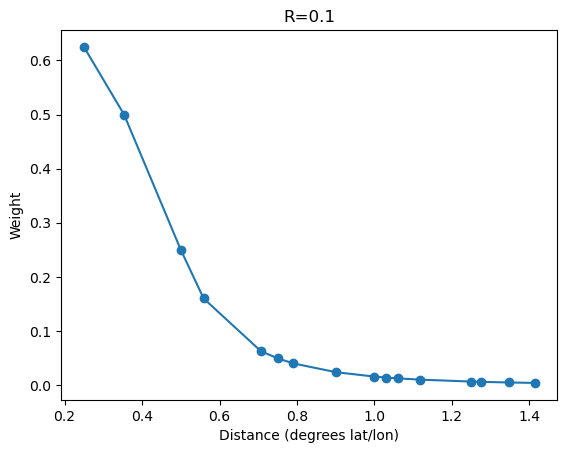

In [37]:
t = 100

coast_label=find_boundaries(lsm)*1

lon = lsm.lon.values
lat = lsm.lat.values
xx,yy = np.meshgrid(lon,lat)
xx = xx.astype(np.float16)
yy = yy.astype(np.float16)    

#Define coastline x,y indices from the coastline mask
xl, yl = np.where(coast_label)

#Get coastline lat lon vectors
yy_t = np.array([yy[xl[t],yl[t]] for t in np.arange(len(yl))])
xx_t = np.array([xx[xl[t],yl[t]] for t in np.arange(len(xl))])

#Repeat the 2d lat lon array over a third dimension (corresponding to the coast dim)
yy_rep=np.repeat(yy[:,:,np.newaxis],yl.shape[0],axis=2)
xx_rep=np.repeat(xx[:,:,np.newaxis],xl.shape[0],axis=2)
stack = np.zeros(xx_rep.shape,dtype=np.complex64)
#for t in tqdm.tqdm(range(yl.shape[0])):
    #stack[:,:,t] = (yy_rep[:,:,t] - yy_t[t])*1j + (xx_rep[:,:,t] - xx_t[t])    
stack = (yy_rep[:,:,t] - yy_t[t])*1j + (xx_rep[:,:,t] - xx_t[t])    

#Compute the differences in complex space over all coastline points. Reorder for to work with the array easier
#stack = np.moveaxis(stack, -1, 0)

weights = ((1/(np.abs(stack)))**4).astype(np.float16)

#x = np.unique(np.sort(np.abs(stack)[100].flatten())[0:100])
x = np.unique(np.sort(np.abs(stack).flatten())[0:100])
plt.plot(x, (1/x**4), marker="o")
plt.xlabel("Distance (degrees lat/lon)")
plt.ylabel("Weight")

plt.figure()
plt.plot(x, get_weights(x, 4, 2, 0.1, -1),marker="o")
plt.xlabel("Distance (degrees lat/lon)")
plt.ylabel("Weight")
plt.title("R=0.1")

plt.figure()
plt.plot(x, get_weights(x, 4, 2, 0.5, -1),marker="o")
plt.xlabel("Distance (degrees lat/lon)")
plt.ylabel("Weight")
plt.title("R=0.1")

In [156]:
#Play around with interpolation over coastline

R=0.2

#From the land sea mask define the coastline and a label array
coast_label = find_boundaries(lsm)*1
land_label = lsm.values

#Get lat lon info for domain and coastline, and convert to lower precision
lon = lsm.lon.values
lat = lsm.lat.values
xx,yy = np.meshgrid(lon,lat)
xx = xx.astype(np.float16)
yy = yy.astype(np.float16)    

#Define coastline x,y indices from the coastline mask
xl, yl = np.where(coast_label)

#Get coastline lat lon vectors
yy_t = np.array([yy[xl[t],yl[t]] for t in np.arange(len(yl))])
xx_t = np.array([xx[xl[t],yl[t]] for t in np.arange(len(xl))])

#Repeat the 2d lat lon array over a third dimension (corresponding to the coast dim)
yy_rep=np.repeat(yy[:,:,np.newaxis],yl.shape[0],axis=2)
xx_rep=np.repeat(xx[:,:,np.newaxis],xl.shape[0],axis=2)

#Compute the differences in complex space for each coastline points. 
stack = np.zeros(xx_rep.shape,dtype=np.complex64)
for t in tqdm.tqdm(range(yl.shape[0])):
    stack[:,:,t] = (yy_rep[:,:,t] - yy_t[t])*1j + (xx_rep[:,:,t] - xx_t[t])    
del yy_rep,xx_rep

#Reorder to work with the array easier
stack = np.moveaxis(stack, -1, 0)

#Get the real part of the complex numbers
stack_abs = np.abs(stack,dtype=np.float32)

#Create an inverse distance weighting function
#weights = get_weights(np.abs(stack), p=4, q=2, R=R, slope=-1)
weights = get_weights(stack_abs, p=4, q=2, R=R, slope=-1)

#Take the weighted mean and convert complex numbers to an angle
mean = np.mean( (weights*stack) , axis=0)
mean_angles = np.angle(mean)
mean_abs = np.abs(mean)

100%|██████████| 1804/1804 [00:02<00:00, 684.93it/s]


In [157]:
#Flip the angles inside the coastline for convention, and convert range to 0 to 2*pi
mean_angles = np.where(land_label==1,(mean_angles+np.pi) % (2*np.pi),mean_angles % (2*np.pi))

#Convert angle back to complex to do interpolation across the coastline
mean_complex = mean_abs * np.exp(1j*mean_angles)

#Do the interpolation
points = mean_complex.ravel()
valid = ~np.isnan(points)
points_valid = points[valid]
xx, yy = np.meshgrid(lsm.lon.values, lsm.lat.values)
xx, yy = xx.ravel(), yy.ravel()
xxv = xx[valid]
yyv = yy[valid]
interpolated = scipy.interpolate.griddata(np.stack([xxv, yyv]).T, points_valid, (xx, yy), method="linear").reshape(lsm.shape)

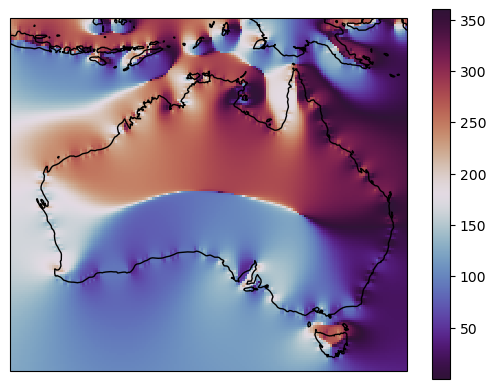

In [158]:
ax=plt.axes(projection=ccrs.PlateCarree())
xr.DataArray(-np.rad2deg(np.angle(interpolated))%360,coords={"lat":lat,"lon":lon}).plot(cmap="twilight_shifted")
ax.coastlines()

In [88]:


#Get angle
interpolated = np.angle(interpolated)    

#Flip the angles inside the coastline for convention, and convert range to 0 to 2*pi
#interpolated = np.where(land_label==1,(interpolated+np.pi) % (2*np.pi),interpolated % (2*np.pi))

#interpolated = -np.rad2deg(interpolated) + 360

xr.DataArray(interpolated,coords={"lat":lat,"lon":lon}).hvplot(cmap="twilight_shifted",height=600,width=800)

:Image   [lon,lat]   (value)